<a href="https://colab.research.google.com/github/KevinLuisLima/Modelo_neural_identificador/blob/main/Modelo_Identifica_Salas_Vazias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, preprocessing
import matplotlib.pyplot as plt
import os
import shutil
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image

### *Carregando e normalizando os dados*

In [ ]:
# Montar o Google Drive
drive.mount('/content/drive')

# Caminho do arquivo no Google Drive
data_dir = '' #insira aqui o path
print("Arquivos no diretório:")
print(os.listdir(data_dir))
sub_dirs = os.listdir(data_dir)
print("Subpastas (classes) no diretório:")
print(sub_dirs)
for sub_dir in sub_dirs:
    sub_path = os.path.join(data_dir, sub_dir)
    print(f"Arquivos em {sub_path}: {os.listdir(sub_path)}")

# Parâmetros do dataset
batch_size = 32
img_height = 448
img_width = 448

# Criar o dataset de imagens a partir do diretório
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.8,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Normalizar os valores dos pixels para o intervalo [0,1]
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Configurar o cache e pré-busca para melhorar o desempenho
AUTOTUNE = tf.data.AUTOTUNE
train_ds = normalized_train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = normalized_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Arquivos no diretório:
['Salas vazias', 'Salas com pessoas']
Subpastas (classes) no diretório:
['Salas vazias', 'Salas com pessoas']
Arquivos em /content/drive/MyDrive/Estudos/UPE/2025/Administração e integração de sistemas/Bases de imagens/Salas vazias: ['imagem_2025-04-28_143606382.png', 'imagem_2025-04-28_143648912.png', 'imagem_2025-04-28_143701187.png', 'imagem_2025-04-28_143711566.png', 'imagem_2025-04-28_143722790.png', 'imagem_2025-04-28_143735353.png', 'imagem_2025-04-28_143745628.png', 'imagem_2025-04-28_143839048.png', 'imagem_2025-04-28_143853629.png', 'imagem_2025-04-28_143908300.png', 'imagem_2025-04-28_143918168.png', 'imagem_2025-04-28_143939169.png', 'imagem_2025-04-28_143950526.png', 'imagem_2025-04-28_143959310.png', 'imagem_2025-04-28_144010178.png', 'imagem_2025-04-28_144020133.png', 'imagem_2025-04-28_144040500.png', 'imagem_2025-04-28_1

### *Definindo a estrutura da CNN*

In [ ]:
model = models.Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')  # 2 classes: salas com gente e sem gente
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


### *Compilando e treinando o modelo*
##### *otimizador: Adam*
##### *função de perda: loss='sparse_categorical_crossentropy'*
##### *Métricas de Avaliação: metrics=['accuracy']*

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 436s 15s/step - accuracy: 0.6694 - loss: 3.2881 - val_accuracy: 0.8651 - val_loss: 0.2895
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 415s 15s/step - accuracy: 0.9031 - loss: 0.2229 - val_accuracy: 0.8977 - val_loss: 0.2453
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 412s 15s/step - accuracy: 0.9592 - loss: 0.1025 - val_accuracy: 0.8744 - val_loss: 0.4591
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 410s 15s/step - accuracy: 0.9716 - loss: 0.0783 - val_accuracy: 0.8744 - val_loss: 0.4167
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 437s 16s/step - accuracy: 0.9827 - loss: 0.0513 - val_accuracy: 0.8930 - val_loss: 0.3152
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 416s 15s/step - accuracy: 0.9855 - loss: 0.0385 - val_accuracy: 0.8791 - val_loss: 0.3133
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 429s 16s/step - accuracy: 0.9890 - loss: 0.0233 - val_accuracy: 0.8837 - val_loss: 0.4057
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 425s 15s/step - accuracy: 0.9806 - loss: 0.0404 - val_accuracy: 0.

### *Visualizando os resultados*

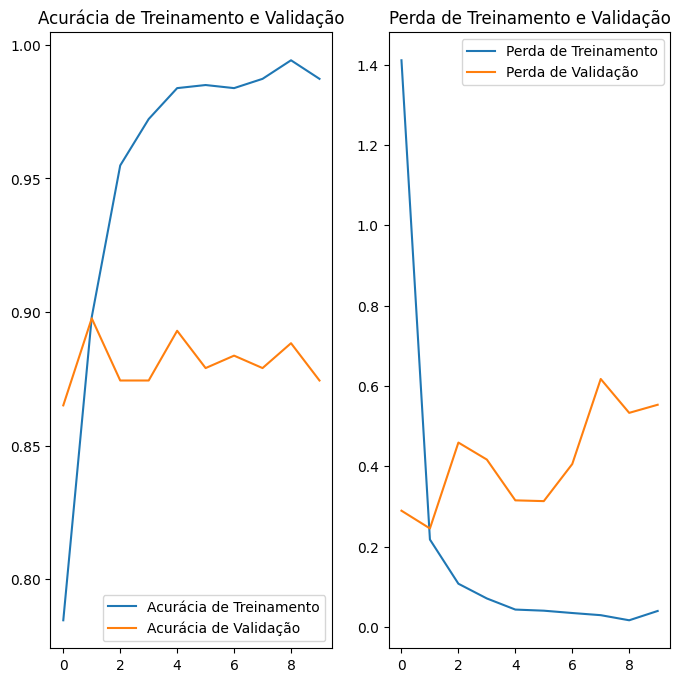

In [ ]:
# Plotar os gráficos de perda e acurácia
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Acurácia de Treinamento')
plt.plot(range(epochs), val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de Treinamento e Validação')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Perda de Treinamento')
plt.plot(range(epochs), val_loss, label='Perda de Validação')
plt.legend(loc='upper right')
plt.title('Perda de Treinamento e Validação')
plt.show()

In [ ]:
# Fazer previsões nos dados de validação
val_predictions = model.predict(val_ds)
val_labels = np.concatenate([y for x, y in val_ds], axis=0)

# Converter previsões em rótulos
val_pred_labels = np.argmax(val_predictions, axis=1)

# Calcular precisão, recall e F1 score
# Fazer previsões nos dados de validação
val_predictions = model.predict(val_ds)
val_labels = np.concatenate([y for x, y in val_ds], axis=0)

# Converter previsões em rótulos
val_pred_labels = np.argmax(val_predictions, axis=1)

# Obter os nomes das classes do dataset de validação
class_names = ['c-gente', 's-gente']
print("Classification Report:")
print(classification_report(val_labels, val_pred_labels, target_names=class_names))

# Calcular e exibir a matriz de confusão
print("Confusion Matrix:")
conf_matrix = confusion_matrix(val_labels, val_pred_labels)
print(conf_matrix)

7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step
Classification Report:
              precision    recall  f1-score   support

     c-gente       0.93      0.84      0.88       120
     s-gente       0.82      0.92      0.87        95

    accuracy                           0.87       215
   macro avg       0.87      0.88      0.87       215
weighted avg       0.88      0.87      0.87       215

Confusion Matrix:
[[101  19]
 [  8  87]]


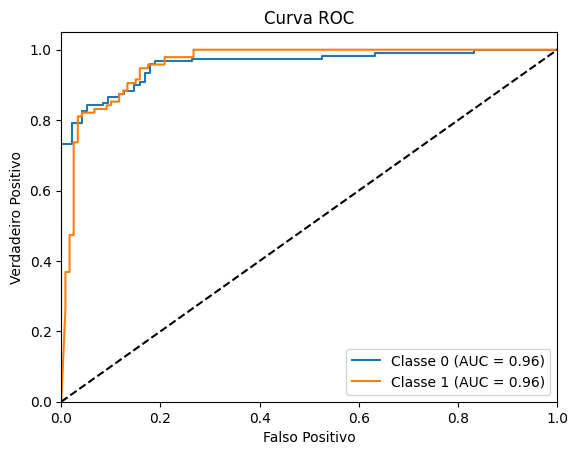

In [ ]:
# Binarizar os rótulos reais para o cálculo da curva ROC
val_labels_bin = tf.keras.utils.to_categorical(val_labels, num_classes=2)

# Calcular a curva ROC e a AUC para cada classe
fpr = {}
tpr = {}
roc_auc = {}

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(val_labels_bin[:, i], val_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotar a curva ROC
plt.figure()
for i in range(2):
    plt.plot(fpr[i], tpr[i], label=f'Classe {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

### *Salvando e testando o modelo*

In [ ]:
def prepare_image(img_path, img_height, img_width):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Criar um batch com uma única imagem
    img_array = img_array / 255.0  # Normalizar a imagem
    return img_array

def classify_image(img_path, model, class_names):
    img_array = prepare_image(img_path, img_height, img_width)
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction[0])  # Obter o índice da classe com maior probabilidade
    return class_names[predicted_class_index]


In [ ]:
model.save('path/to/save/your/model.keras')